# Simulating a Stellar Flybys using [`REBOUND`](https://rebound.readthedocs.io/en/latest/index.html).

## Details

The `flyby` function in `flybys.py` uses three main characteristics of the flyby star to compute the initial conditions of the flyby star: the mass of the flyby star $m_\star$, the impact parameter $b_\star$, and the hyperbolic excess velocity $v_\star$. We found that these three parameters are the easiest to work with when drawing samples from distributions that define various stellar environments. Differences between stellar environments are essentially delineated by the stellar density $n$, the stellar mass distribution $\mathcal{M}$, and the stellar velocity dispersion $\bar{v}$. The average encounter rate can then be calculated using
$$ \Gamma = \langle n \sigma \bar{v} \rangle$$
where $\sigma$ is the cross-section of the system of interest. In practice the average encounter rate is calculated using the product of the averages rather than the average of the products. Thus, the three main components of the stellar flyby ($m_\star$, $v_\star$, and $b_\star$) can be drawn from the stellar mass distribution, the stellar velocity distribution (defined by the velocity dispersion), and uniformly across the cross-sectional area.

We found that  when probing changes to a system from an adiabatic flyby (when the velocity of the incoming star is much less than the velocity of the planets) it is important to begin with the star at least $10^6\,\mathrm{AU}$ away from the Sun.

## Three-body system flyby (Sun-Neptune and flyby star).

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# See accompaning Python script for implementation details.
from flybys import flyby

### Define constants and parameters

In [2]:
pi = np.pi
twopi = 2.*pi
to_deg = 180.0/pi

# Basic orbital elements of Neptune
planet_mass = 5.151383772628674e-05 # Msun
planet_a = 30.27762143269065 # AU
planet_e = 0.012971767987242259
# More if you don't want Neptune to be planar.
planet_inc = 0.030870657846206642
planet_omega = 4.337864438269479
planet_Omega = 2.2992717711122466

# Set the orbital elements of the flyby star
# Simulate a randomly oriented, 1 solar mass stellar flyby with relative velocity of 5 km/s, and an impact parameter of 150 AU.
star_mass = 1 # Msun
star_v = 5 # km/s
star_b = 150 # AU
star_inc = np.random.uniform(-pi, pi)
star_omega = np.random.uniform(-pi, pi)
star_Omega = np.random.uniform(-pi, pi)
print('star_inc:   {0:7.2f}°'.format(star_inc * to_deg))
print('star_omega: {0:7.2f}°'.format(star_omega * to_deg))
print('star_Omega: {0:7.2f}°'.format(star_Omega * to_deg))

star_inc:     86.84°
star_omega:  163.22°
star_Omega:  -85.23°


### Setup a two-body simulation and run a flyby simulation.

In [3]:
def setup(planet_mass=5.151383772628674e-05, planet_a=30.27762143269065, planet_e=0.012971767987242259, planet_inc=0, planet_omega=0, planet_Omega=0, planet_f=0):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=1)
    sim.add(m=planet_mass, a=planet_a, e=planet_e, inc=planet_inc, omega=planet_omega, Omega=planet_Omega, f=planet_f)
    
    sim.integrator = 'whckl'
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.05 * sim.particles[1].P
    sim.move_to_com()
    return sim

#### The setup, the flyby, and the outcome.

Before the Flyby


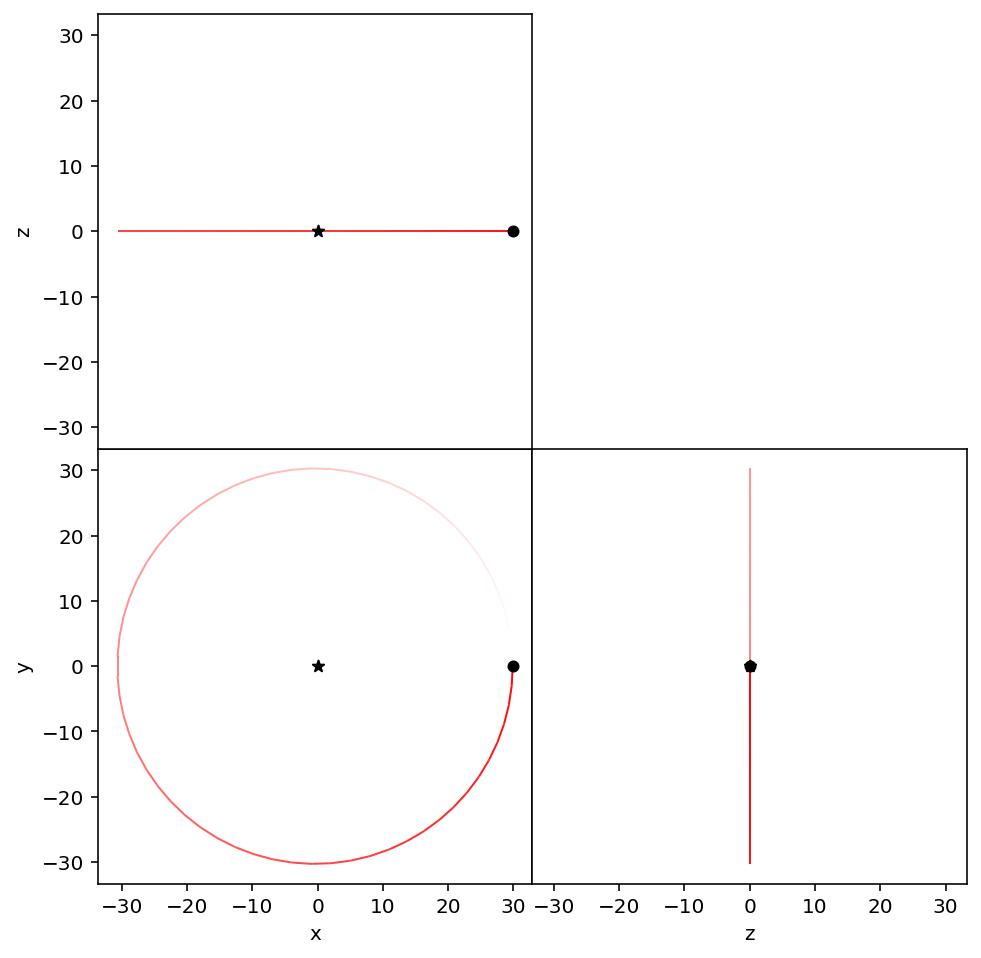

During the Flyby


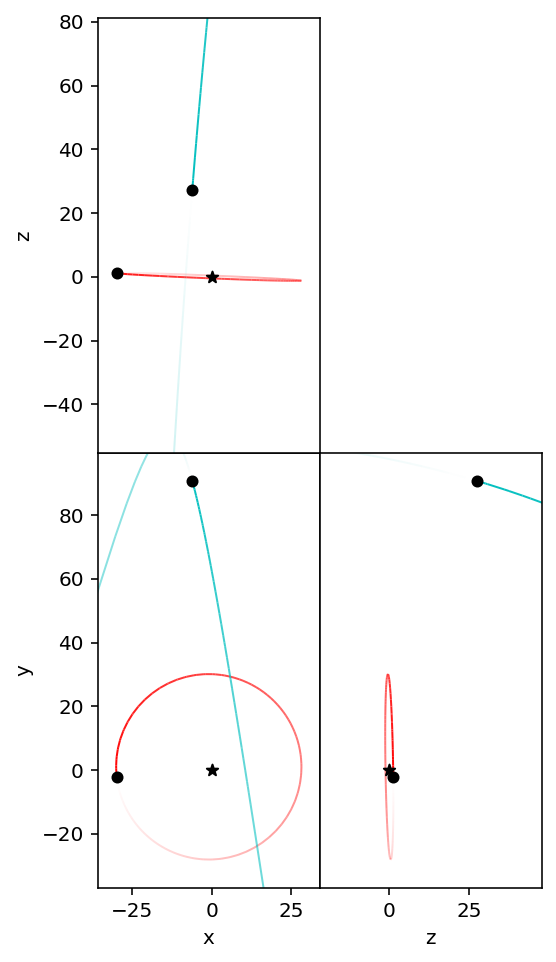

After the Flyby


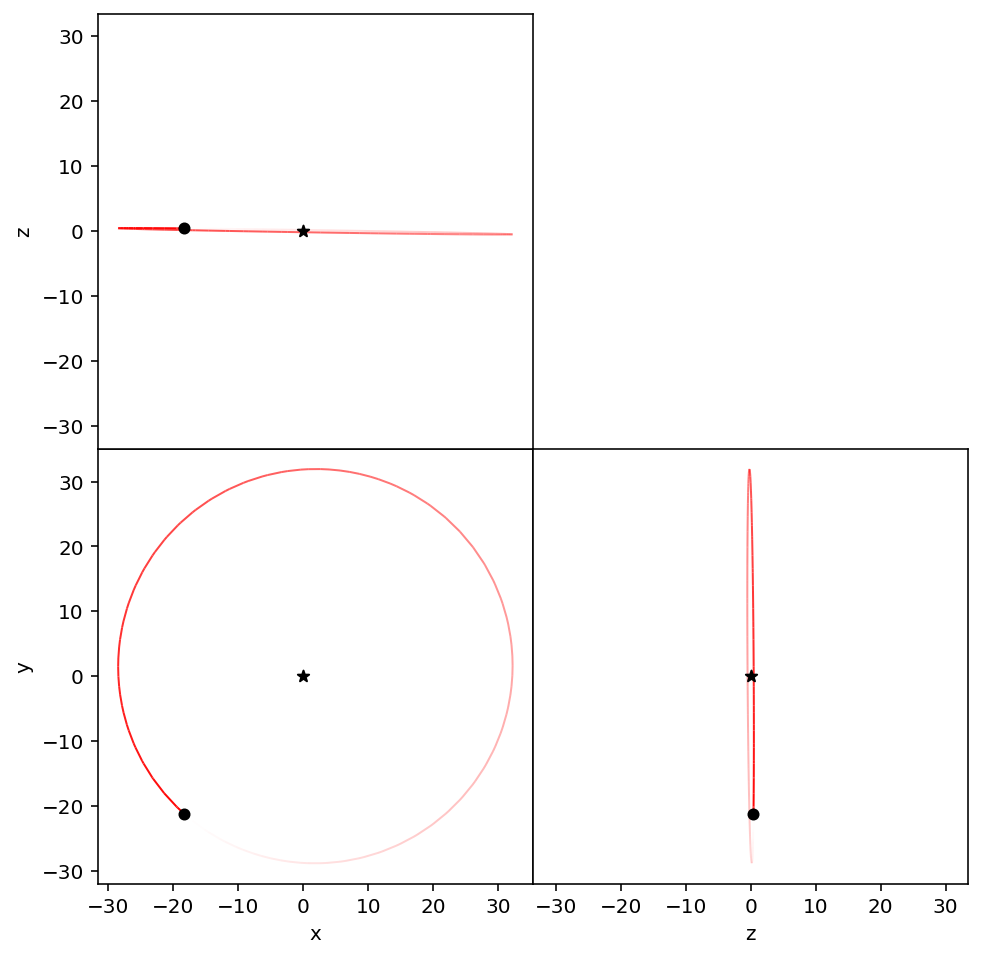

In [4]:
sim = setup()

print('Before the Flyby')
rebound.OrbitPlot(sim, slices=True, color=True);
plt.show()

flyby(sim, star_mass=star_mass, star_b=star_b, star_v=star_v, star_inc=star_inc, star_omega=star_omega, star_Omega=star_Omega, showflybysetup=True) 

print('After the Flyby')
rebound.OrbitPlot(sim, slices=True, color=True);
plt.show()

#### Rerun the same flyby and investigate how the system changed.

In [5]:
sim = setup()

Ei = sim.calculate_energy()
orb = sim.calculate_orbits()
ai = orb[0].a
ei = orb[0].e

flyby(sim, star_mass=star_mass, star_b=star_b, star_v=star_v, star_inc=star_inc, star_omega=star_omega, star_Omega=star_Omega) 

Ef = sim.calculate_energy()
orb = sim.calculate_orbits()
af = orb[0].a
ef = orb[0].e

dE = np.abs((Ef-Ei)/Ei)
da = np.abs((af-ai)/ai)
de = np.abs((ef-ei)/ei)

print('Relative Changes:')
print('dE/E = {0:1.5e}'.format(dE))
print('da/a = {0:1.5e}'.format(da))
print('de/e = {0:1.5e}'.format(de))

Relative Changes:
dE/E = 4.26959e-03
da/a = 4.28790e-03
de/e = 5.18339e+00


### Investigate the effects from impact parameter.

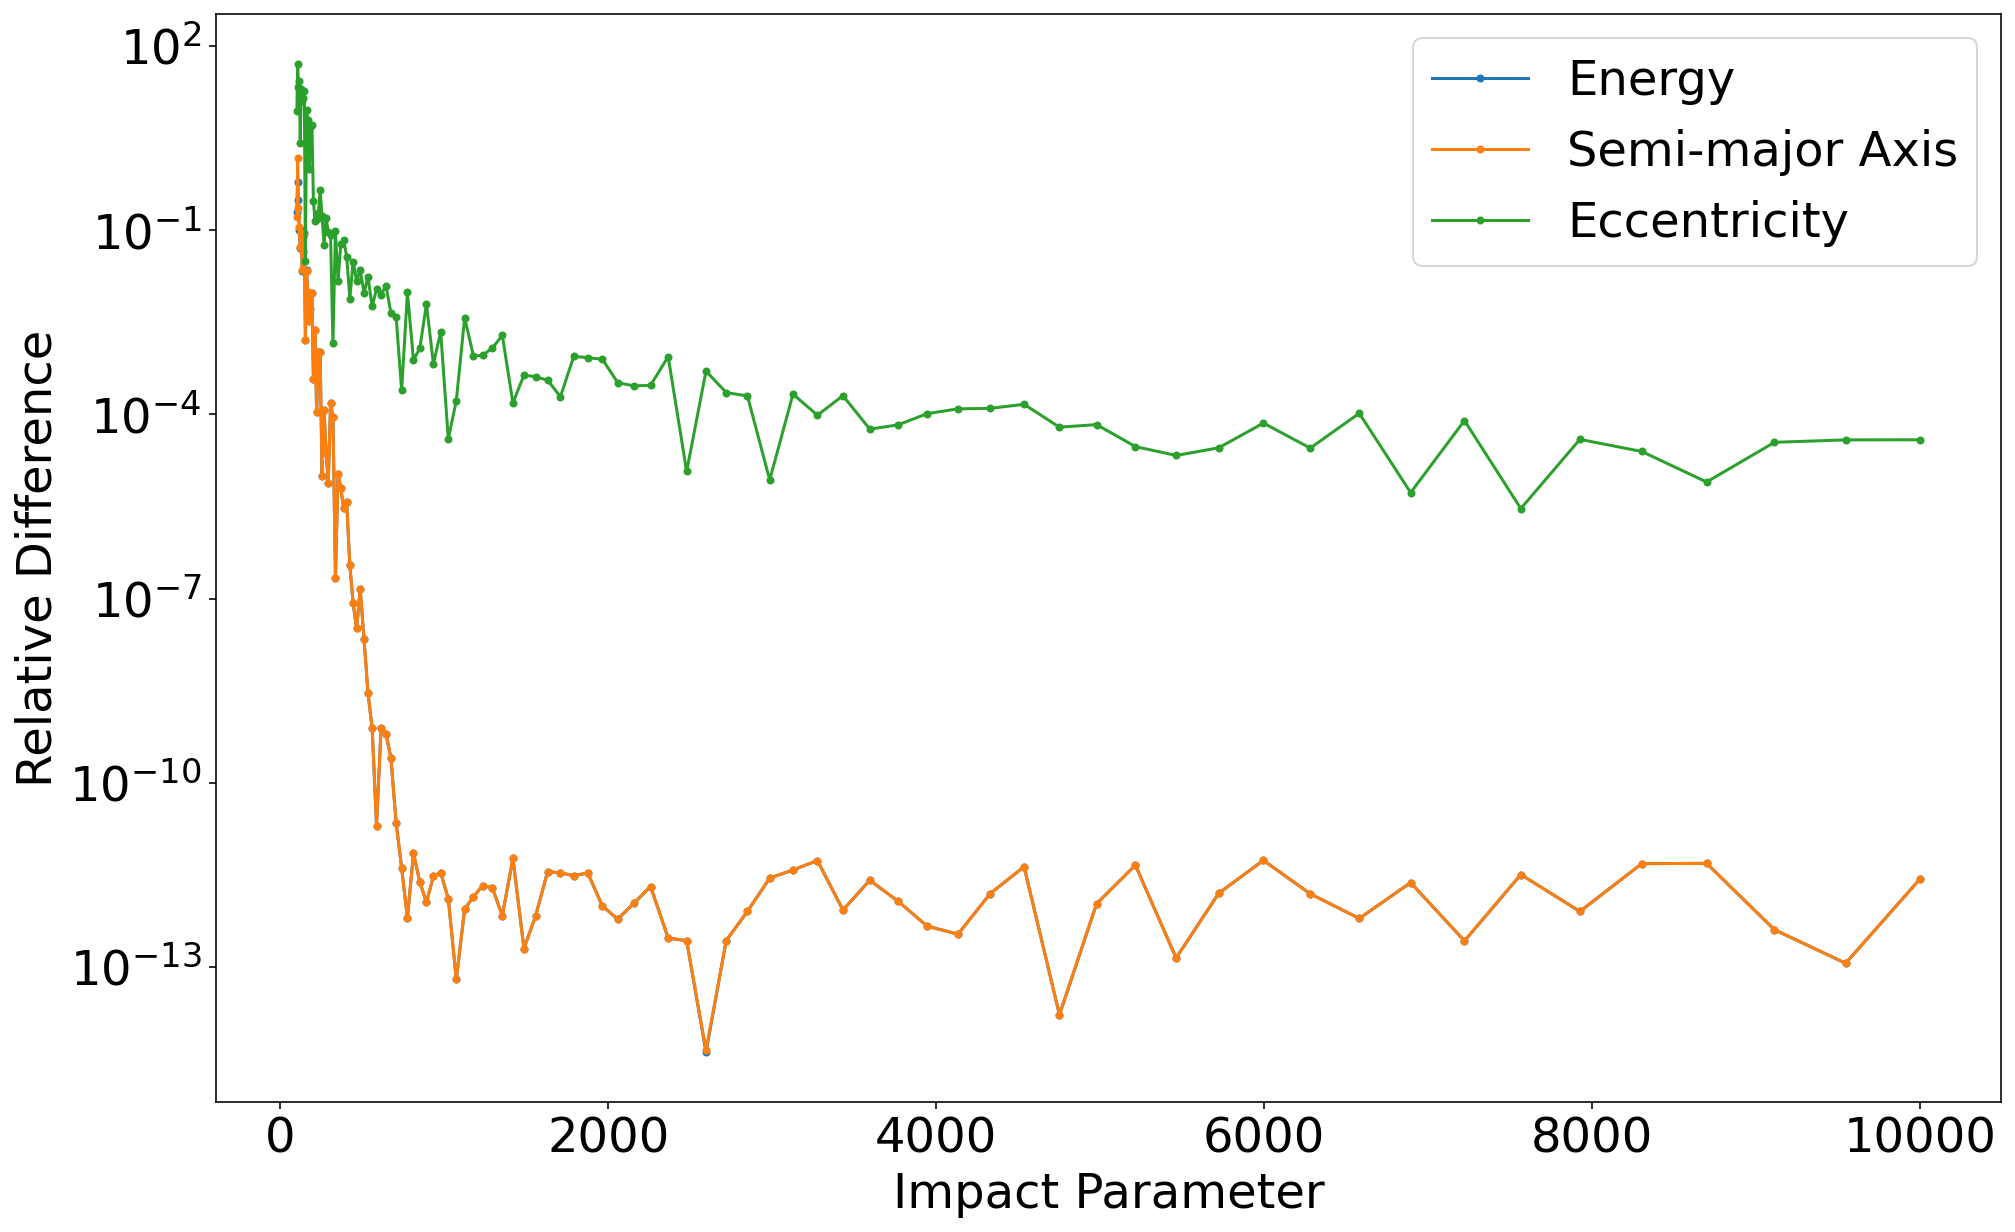

In [19]:
Nflybys = 100
energy = np.zeros(Nflybys+1)
a = np.zeros(Nflybys+1)
e = np.zeros(Nflybys+1)

sim = setup()
energy[0] = sim.calculate_energy()
orb = sim.calculate_orbits()
a[0] = orb[0].a
e[0] = orb[0].e

star_bs = np.logspace(2, 4, Nflybys)

for i in range(Nflybys):
    sim = setup()
    flyby(sim, star_mass=star_mass, star_b=star_bs[i], star_v=star_v) 
    energy[i+1] = sim.calculate_energy()
    orb = sim.calculate_orbits()
    a[i+1] = orb[0].a
    e[i+1] = orb[0].e

dE = np.abs((energy[1:]-energy[0])/energy[0])
da = np.abs((a[1:]-a[0])/a[0])
de = np.abs((e[1:]-e[0])/e[0])

plt.rcParams.update({'font.size': 24})
fig,ax = plt.subplots(1,1, figsize=(16,10))
ax.plot(star_bs, dE, '.-', label='Energy')
ax.plot(star_bs, da, '.-', label='Semi-major Axis')
ax.plot(star_bs, de, '.-', label='Eccentricity')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Impact Parameter')
ax.set_ylabel('Relative Difference')
plt.show()